<a href="https://colab.research.google.com/github/semueller/LecturePatternRec2_Draft/blob/main/ExercisesJupyter/exercise3/PR_sheet3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import numpy as np
import numpy.linalg as la
import numpy.random as rnd

import matplotlib.colors as clr
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import imageio as imageio

import scipy.spatial as spt
from scipy.spatial.distance import cdist

# Pattern Recognition 2 - Assignment 3

---
## Exercise 1 - Whitened data is of unit covariance

In *lecture 08*, we briefly looked at data pre-processing techniques such as **data whitening**. Recall that, if we are given an $m\times n$ data matrix $X$ of real valued vectors, then the process of whitening these data consists of the following three steps:
1. compute the transformation $Y=X(\mathbb{I}-\frac{1}{n}\textbf{1}\textbf{1}^\intercal$
1. determine the spectral decomposition $\frac{1}{n}YY^\intercal=U\Lambda U^\intercal$
1. compute the transformation $Z=U\Lambda^{-\frac{1}{2}} U^\intercal Y

(Note that $U\in\mathcal{O}_m(\mathbb{R})$ is orthogonal and $\Lambda=\text{diag}(\lambda)$ is diagonal.)

Also recall, that we claimed the covariance matrix of the dat in $Z$ to be the identity matrix. Your task is now to proe this claim. 

### Proof:

$\begin{align} 
ZZ^{\intercal} &= \big(U \Lambda^{-\frac{1}{2}}U^{\intercal}Y\big) \big(U \Lambda^{-\frac{1}{2}}U^{\intercal}Y \big)^{\intercal}\\
&= U \Lambda^{-\frac{1}{2}}U^{\intercal}YY^{\intercal} U \Lambda^{-\frac{\intercal}{2}}U^{\intercal}\\
&= \frac{1}{n} U \Lambda^{-\frac{1}{2}}U^{\intercal}U \Lambda U^{\intercal} U \Lambda^{-\frac{1}{2}}U^{\intercal}&& \Lambda\text{ is diagonal and }YY^\intercal = n U\Lambda U^\intercal \\
&= \frac{1}{n} U \Lambda^{-\frac{1}{2}} \Lambda  \Lambda^{-\frac{1}{2}}U^{\intercal} && U\text{ is orthogonal}\\
&= \frac{1}{n} U \Lambda^{-\frac{1}{2}} \Lambda^{+\frac{1}{2}}U^{\intercal}\\
&= \frac{1}{n} U U^{\intercal}\\
&= \mathbb{I}&& U\text{ is orthogonal}\\
\end{align}$

---
## Exercise 2 - More on idempotent matrices


In *lecture 07*, we already proved that, if $u\in\mathbb{R}^m$ is a unit vector, then the
outer product matrix $P = uu^\intercal$ is idempotent. Your task is now to establish
a more general result.

Prove that, for any $u\neq 0\in\mathbb{C}^m$, the 
matrix
$$ P = \frac{uu^\dagger}{u^\dagger u}$$
is idempotent.

($u^\dagger$ denotes the complex conjugate transpose of $u$ i.e. $u^\dagger = (u^*)^T$)

### Proof:

$\begin{align}
P^2 &= \frac{uu^\dagger}{u^\dagger u}  \frac{uu^\dagger}{u^\dagger u}\\
&= \frac{1}{(u^\dagger u)^2} uu^\dagger uu^\dagger \\
&= \frac{1}{(u^\dagger u)^2} u (u^\dagger u )u^\dagger\\
&= \frac{u u^\dagger}{u^\dagger u}  = P
\end{align}$

---
## Exercise 3 - Fastmap


**Fastmap** is an algorithm used to **estimate principle components**. This can be useful 
- if it is too expensive to compute the components explicitly or 
- if one is only interested in the first few components. 

The approximated components however can vary quite a lot from the "actual" components. Nevertheless studying the algorithm is worthwhile since the implementation of the algorithm is simple and still deepens the geometrical understanding of principal components.

In [68]:
matX = np.load('faceMatrix.npy').astype('float')
m, n = matX.shape
print(m, n)

361 2429


In [69]:
def get_image(image_nr, show_print=False):
    vecX = np.load('faceMatrix.npy').astype('float')[:,image_nr-1].reshape(19,19)
    plt.imshow(vecX, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

    return vecX

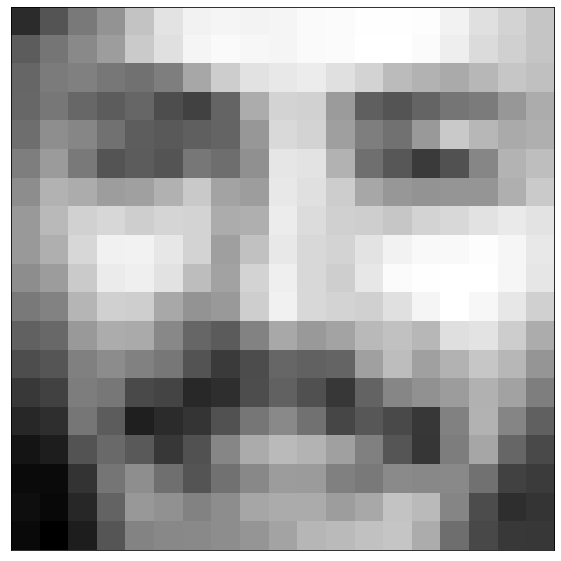

In [70]:
get_image(15, show_print=True)
print()

### 3.1. Implement the fastmap algorithm which we discussed in *lecture 07*. Recall that this algorithm involves a function `GetDistantObjects`. How would you implement it in numpy / scipy?

#### Some helper functions:

In [103]:
def max_dist_idx(X, v):
    """
    This function uses 'scipy.spatial.distance.cdist' to compute
    the distances between each pair of two collections of inputs ('X' and 'v').
    It then returns the index of the maximum such distance.
    This index points to the row in 'X' where the vector with maximum distance
    to 'v' is stored.
    """
    if len(v.shape) == 1:
        v = np.expand_dims(v, 0)
    return np.argmax(cdist(X, v))

In [104]:
def get_distant_objects(X):
    # Select a random vector from the set
    xi = X[np.random.randint(X.shape[0]), :]
    # Get a vector that is maximally distant from the random vector,
    # i.e. that lies on the outskirts of the datacloud
    xj = X[max_dist_idx(X, xi), :]
    # Get the vector that lies furthest from the second vector,
    # i.e. on the other side of the datacloud
    xk = X[max_dist_idx(X, xj), :]
    # Calculate another distant vector in case 'xi' was an unlucky draw
    xl = X[max_dist_idx(X, xk), :]

    return xk, xl

In [73]:
def get_distant_objects_2(X):
    """
    This function is a second implementation. 
    Note that it expects the original shape of 'X' where the images
    were stored in the columns!
    """
    m, n = X.shape

    X = X.T
    i = rnd.randint(n, size=1)
    j = np.argmax(np.sum((X-X[i])**2, axis=1))
    k = np.argmax(np.sum((X-X[j])**2, axis=1))
    l = np.argmax(np.sum((X-X[k])**2, axis=1))
    X = X.T
    
    return X[:,[k,l]]

In [74]:
def approximate_major_component(X):
    # Approximation of major component via difference between two maximally distant vectors
    # This does not take center of mass into account and can "pierce diagonally" through the cloud
    x1, x2 = get_distant_objects(X)
    difference = x1 - x2
    return difference / la.norm(difference)

#### The *fastmap* implementation:

In [137]:
def fastmap(X, n_components=25) -> (np.array, int):
    """
    This is an implementation of the fastmap algorithm. It 
    - takes as input a data matrix X with zero mean and
    - returns the eigenvectors of the covariance matrix of the data (C=1/n X X^T)
    """
    # Copy the data and transform it, such that rows correspond to images
    matX = X.T.copy()

    component_list = []
    I = np.eye(matX.shape[1])

    for k in range(n_components):
        # Approximate the k-th component
        mc = approximate_major_component(matX)
        # Remove it from the data
        matX = matX @ (I - np.outer(mc, mc))
        # Store the identified component
        component_list.append(mc)

    component_list = np.array(component_list).T

    # Check how orthogonal the estimated components are
    maxerr = np.max(np.abs(component_list.T @ component_list - np.eye(n_components)))

    return component_list, maxerr

### 3.2. Run your fastmap implementation to obtain approximations of the top $25$ principal components of the data in matrix $X$.

In [76]:
n_components = 25

In [77]:
np.random.seed(978794)
U_fast, maxerr = fastmap(matX, n_components=n_components)
# U_fast = -1 * U_fast

### 3.3. Compute the SVD of matrix $X$ and determine the top $25$ left singular vectors.

In [78]:
# Calculate the SVD for comparison
U, s, _ = la.svd(matX)#, full_matrices=False)
U = U[:, :n_components]

### 3.4. Compare your fastmap results to your SVD results. A good idea for doing this is to visualize / plot them as tiny images. Figure out how to create a plot that shows not just a single tiny image but $25$ at the same time.

In [79]:
# Prepare a nice print
nrows = np.int(np.sqrt(n_components))
magic_numbers={'nx': nrows, 'ny': nrows, 'w': 19, 'h': 19, 'bg': 1, 'delta': 2}
m = np.max([np.max(np.abs(U_fast)), np.max(np.abs(U))])
U_fast, U = U_fast/m, U/m
U_fast_images = arrangeOnGrid(U_fast, **magic_numbers)

# U_fast_images = (U_fast_images * 255).astype('uint8')
U_images = arrangeOnGrid(U, **magic_numbers)
# U_images = (U_images * 255).astype('uint8')
# U_abs_diff = np.abs(U_fast) - np.abs(U)
# U_ad_images = arrangeOnGrid(U_abs_diff, **magic_numbers)

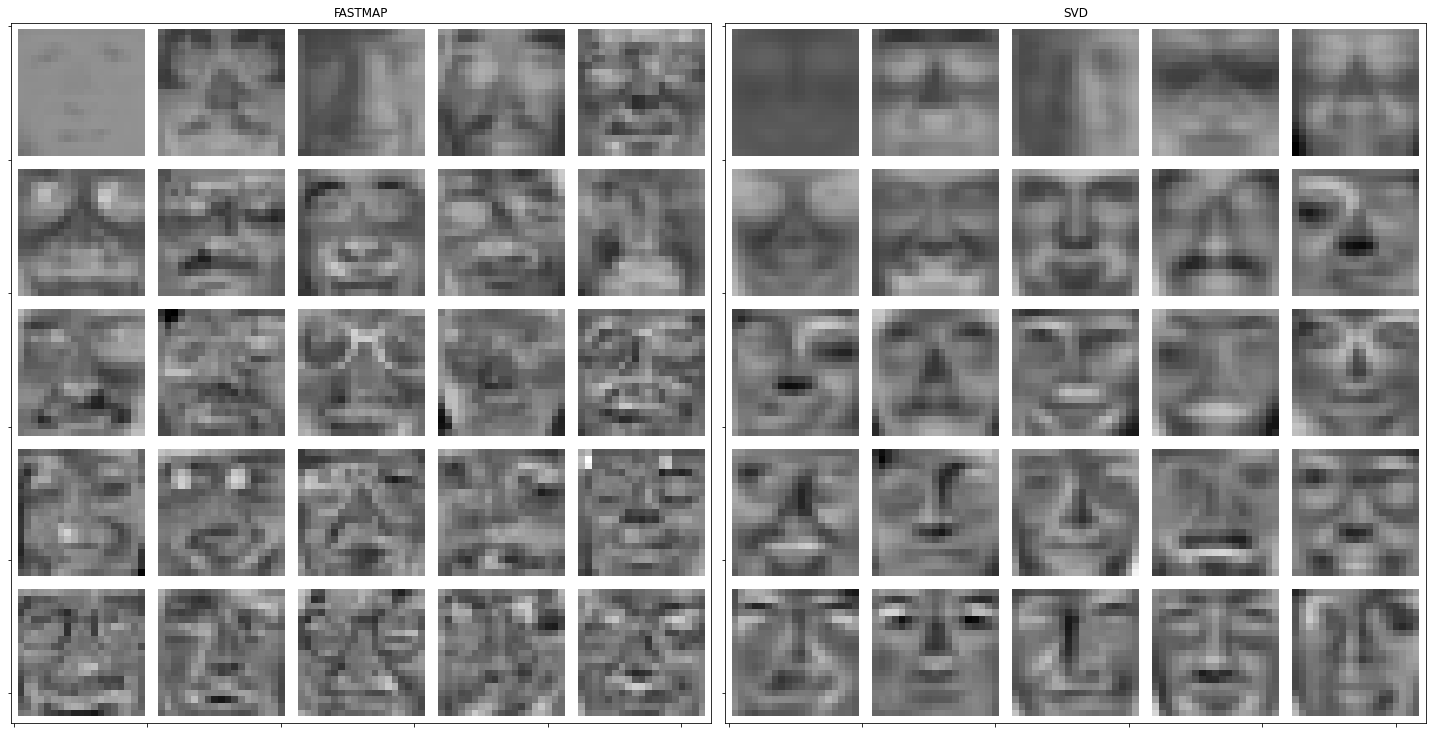

In [80]:
imgs = [U_fast_images, U_images] #, U_ad_images]
labels = ["FASTMAP", "SVD"]
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
for i in range(2):
    im = imgs[i]
    ax = axs[i]
    ax.imshow(im, cmap='gray')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(labels[i])
fig.tight_layout()

We can see that the first 4-5 approximated components indeed look similar to the solutions from obtained from the SVD (up to a factor of $\pm 1$).

---
## Exercise 4 - Hopfield nets: the $k$-rooks problem

In *lecture 10*, we introduced the $k$-rooks problem and saw how to solve it using a Hopfield network. In particular, we considered the special case where $k = 4$. Building on our discussion, here is what you are supposed to do in this task:

### 4.1. Use what we discussed in the lecture to implement a Hopfield net (with asynchronous updates) that solves the $k = 4$ rooks problem. Run your Hopfield net for, say, $100$ iterations.

#### Implementation of a Hopfield network

In [81]:
def signum(x):
    # Activation function for a neuron in a Hopfield network
    return np.where(x >= 0, +1, -1)

In [82]:
def hnet_energy(state_vector, weight_matrix, bias_values):
    # Computes the energy of a Hopfield network
    return -0.5 * state_vector @ weight_matrix @ state_vector + bias_values @ state_vector

Recall: $$H(s) := \frac{1}{2} s^\intercal W s + \theta^\intercal s$$

In [83]:
def hnet_print_time_state_energy(state_vector, weight_matrix, bias_values, t):
    # Compute the energy of the network for the current state 'state_vector'
    s = ' '.join(['+' if x >= 0 else '-' for x in state_vector])
    E = hnet_energy(state_vector, weight_matrix, bias_values)
    print ('{:4d}  {}  {:+.1f}'.format(t, s, E))

In [84]:
def hnet_run_asyn(state_vector, weight_matrix, bias_values, tmax=100, verbose=True):
    '''
    This function runs a Hopfield network for 'tmax' iterations 
    and returns the final state.
    The inputs setup the networks state ('state_vector'), weights ('weight_matrix'),
    and bias ('bias_values').
    If 'verbose' is set, the energy at each step is printed.
    '''
    # Iterate over an array of 'tmax' randomly choosen states of the network
    for t, u in enumerate(np.random.randint(0, len(state_vector), tmax)):
        if verbose:
            hnet_print_time_state_energy(state_vector, weight_matrix, bias_values, t)

        # Update the currently selected state
        state_vector[u] = signum(weight_matrix[u] @ state_vector - bias_values[u])

    return state_vector

Recall: 
$$ s_i = \begin{cases}
		+1 & \text{if } \sum_{j} w_{i,j}s_j \ge \theta_i\\
		-1 & \text{otherwise}
		\end{cases}$$

### 4.1. Run your Hopfield net for, say $100$ iterations and try to visualize the state it ends up in.

In [85]:
def verify_solution(s, k):
    # Remove all '-1' entries ('False')
    s = np.reshape(s, (k,k)) > 0  
    _1 = np.ones(k)
    # Now check if there are exactly 'k' rooks on every row and column
    return np.all(_1 == np.sum(s, 0)) and np.all(_1 == np.sum(s, 1))

In [133]:
def visualize_solution(checkerboard_vector):
    # Print a field which indicates the placed rooks
    dimension = int(np.sqrt(len(checkerboard_vector)))
    plt.pcolormesh(-checkerboard_vector.reshape(dimension, dimension), cmap='hot', edgecolor='k', linewidth=1)
    plt.xticks([])
    plt.yticks([])
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.show()

    is_valid_solution = verify_solution(checkerboard_vector, dimension)
    _val = "valid" if is_valid_solution else "invalid"
    is_valid_solution_str = f"Solution is {_val}"
    return is_valid_solution_str, is_valid_solution

### 4.2. Now implement a Hopfield net that solves the $k = 8$ rooks problem. To this end, you need to redefine or recompute the network parameters $W_r$, $W_c$, $\theta_r$ and $\theta_c$.

Recall the theoretical results from the lecture:
with $J := \big(\textbf{1}\textbf{1}^\intercal - \mathbb{1}\big) \in\mathbb{R}^{m\times m}$ we set:
$$ W := -\frac{1}{2}\begin{bmatrix}
    J & \mathbb{I} & \dots & \mathbb{I}\\
	\mathbb{I} & J & \dots & \mathbb{I}\\
	\vdots & \vdots & \ddots & \vdots\\
	\mathbb{I} & \mathbb{I} & \dots & J\\
	\end{bmatrix}\in \mathbb{R}^{k^2\times k^2} \qquad\text{and}\qquad \theta := (k-2)\textbf{1} \in \mathbb{R}^{k^2} $$

which was derived in a proof by considering optimization with respect to rows and columns separately first, and then joining them in $W=W_r +W_c$ and $\theta = \theta_r + \theta_c$. Where

$$ W_r := -\frac{1}{2}\begin{bmatrix}
	J & 0 & \dots & 0\\
	0 & J & \dots & 0\\
	\vdots & \vdots & \ddots & \vdots\\
	0 & 0 & \dots & J\\
	\end{bmatrix}\in \mathbb{R}^{k^2\times k^2} \qquad\text{and}\qquad \theta_r := \frac{1}{2}(k-2)\textbf{1}\in \mathbb{R}^{k^2} $$

and
$$ W_c := -\frac{1}{2}\begin{bmatrix}
	0 & \mathbb{I} & \dots & \mathbb{I}\\
	\mathbb{I} & 0 & \dots & \mathbb{I}\\
	\vdots & \vdots & \ddots & \vdots\\
	\mathbb{I} & \mathbb{I} & \dots & 0\\
	\end{bmatrix}\in \mathbb{R}^{k^2\times k^2} \qquad\text{and}\qquad \theta_c := \frac{1}{2}(k-2)\textbf{1} \in \mathbb{R}^{k^2} $$

In [119]:
# Variable setup
k = 9

Note that the initialization of the weight matrices could be done using `np.block()`. However, it is desirable to avoid for-loops and spend as mucht time in highly optimized fortran/c code as possible. Hence one may prefer to use the Kronecker product `np.kron()` as done here:

In [54]:
def k_rooks_hnet_setup(k):
    n = k**2
    vec1 = np.ones(n)
    mat1 = np.ones((k,k))
    matI = np.eye(k)
    matJ = mat1 - matI
    # Optimization w.r.t. rows
    vecTr =  0.5 * (k-2) * vec1
    matWr = -0.5 * np.kron(matI, matJ)
    # Optimization w.r.t. columns
    vecTc =  0.5 * (k-2) * vec1
    matWc = -0.5 * np.kron(matJ, matI)
    # Add the two optimizations
    vecT  = vecTr + vecTc
    matW  = matWr + matWc
    # Initialize the Hopfield network with all states set to one (rooks everywhere)
    vecS = np.ones(n)
    return vecS, matW, vecT

In [47]:
tmax = 1000
k=8
print(k)
states, weights, biases = k_rooks_hnet_setup(k)
# Run the Hopfield network
vecS = hnet_run_asyn(states, weights, biases, tmax, verbose=False)

8
[14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14.
 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14.
 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14. 14.
 14. 14. 14. 14. 14. 14. 14. 14. 14. 14.]


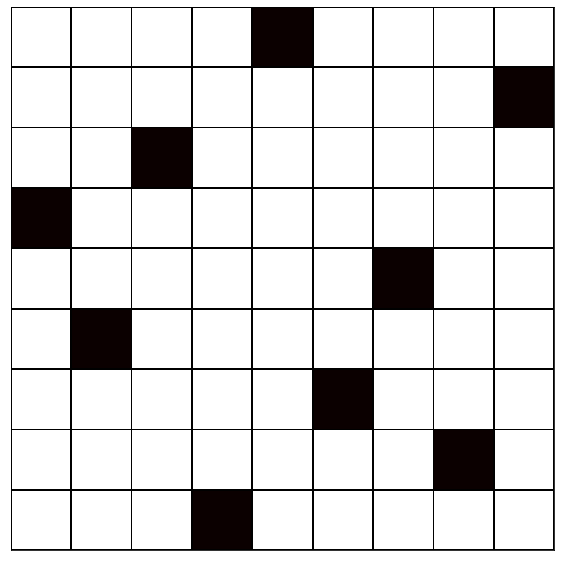

Solution is valid


In [134]:
answer, _ = visualize_solution(vecS)
print(answer)

In [55]:
## Note: In practice we found that computing theta with (k-1) instead of (k-2) returns a correct solution de facto always; uncomment the code to see for yourself.
# CODE FOR TESTING
# def kminus1_rooks_hnet_setup(k):
#     n = k**2
#     vec1 = np.ones(n)
#     mat1 = np.ones((k,k))
#     matI = np.eye(k)
#     matJ = mat1 - matI
#     # Optimization w.r.t. rows
#     vecTr =  0.5 * (k-1) * vec1
#     matWr = -0.5 * np.kron(matI, matJ)
#     # Optimization w.r.t. columns
#     vecTc =  0.5 * (k-1) * vec1
#     matWc = -0.5 * np.kron(matJ, matI)
#     # Add the two optimizations
#     vecT  = vecTr + vecTc
#     matW  = matWr + matWc
#     # Initialize the Hopfield network with all states set to one (rooks everywhere)
#     vecS = np.ones(n)
#     return vecS, matW, vecT

# kminusOne, knormal = {}, {}
# niter = 500
# tmax = 1000
# for k in [4, 8]:
#     kminusOne[k] = 0; knormal[k] = 0
#     for i in range(niter):
#         states, weights, biases = k_rooks_hnet_setup(k)
#         vecS = hnet_run_asyn(states, weights, biases, tmax, verbose=False)
#         knormal[k] += verify_solution(vecS, k)
        
#         states, weights, biases = kminus1_rooks_hnet_setup(k)
#         vecS = hnet_run_asyn(states, weights, biases, tmax, verbose=False)
#         kminusOne[k] += verify_solution(vecS, k)
#     knormal[k] /= niter
#     kminusOne[k] /= niter
# print(knormal)
# print(kminusOne)

{4: 0.56, 8: 0.2}
{4: 1.0, 8: 1.0}


---
## Exercise 5 - Hopfield nets: finding maximally different images

Once again consider the matrix $X$ of tiny images from *task 3.3*. However, let us simplify things and only consider the first $100$ of these images.

In [92]:
matX = matX[:,:100]

Given this truncated version of matrix $X$, standardize the data it contains and store the result in a matrix $Y$.

Next, given this new matrix $Y$, compute a squared Euclidean distance matrix $D^{n\times n}$ where, in our case $n = 100$ and
$$ D_{i,j} = ||y_i-y_j||^2$$

If you do not know how to do this efficiently, you might want to consult: 

`C. Bauckhage, “NumPy / SciPy Recipes for Data Science: Squared
Euclidean Distance Matrices”, technical report, 2014`

Now, recall that, in *sheet 01*, we were concerned with the problem of finding $k$ data points that are as far apart as possible. Back then, we formalized this problem as follows:
$$ S^* = \underset{S\subset X}{\text{argmax}} \sum\limits_{y_i\in S}\sum\limits_{y_j\in S} ||y_i-y_j||^2 $$
$$\text{s.t.}\qquad |S|=k$$

$$ z^* = \underset{z\in \{0, 1\}^n}{\text{argmax}}\ z^\intercal D z$$
$$\text{s.t.} \ \mathbf{1^\intercal}z = k $$

(Note that $(D)_{ij} = ||x_i - x_j||^2$ for $x\in X$.)

This looks like a problem a Hopfield network could handle! So, go ahead
and implement a Hopfield network that computes $z^*$. Run your Hopfield net for several choices of $k \in \{9, 16, 25\}$.

**Note**: The last optimization problem is written in terms of binary vectors $z$. However, for the Hopfield networks we are interested in, we require problem formulations in terms of bipolar vectors $s$. 
That is, you’ll need to rewrite the problem as a
**QUBO** that minimizes over bipolar vectors (and make sure that the resulting weight matrix is hollow) before you implement the Hopfield net.

**Note**: Your Hopfield net will end up in a state $s\in\{-1,+1\}^n$. If all goes well, $k$ entries of $s$ will have a value of $+1$ and the remaining $n-k$ entries will have a value of $-1$. The $+1$ entries of $s$ will index $k$ maximally diverse
columns of $Y$. However, $Y$ is a standardized version of $X$. Hence, to visualize the outcome of your Hopfield network computations, use the resulting state vector $s$ as an index into the columns of $X$ and visualize the images
you obtain this way.

#### Theoretical solution:

We need to convert it into a QUBO which has the form: 
$$ s^* = \underset{s\in \{\pm 1\}^n}{\text{argmin}} -\frac{1}{2} s^\intercal W s + \theta^\intercal s$$

To solve the QUBO with a Hopfield network keep in mind, that $W$ needs to be *hollow* and *symmetric*!

##### Reformulate the original problem as a minimization problem:

$$ z^* = \underset{z\in \{0, 1\}^n}{\text{argmin}}\ -z^\intercal D z$$
$$\text{s.t.} \ \mathbf{1^\intercal}z = k $$

Reformulate constraint: $\mathbf{1^\intercal}z = k \ \iff\  (\mathbf{1^\intercal}z - k)^2 = 0$

##### Introducing the constraint as a Lagrangian:

$\begin{eqnarray}
&L(z, \lambda) \\
&=& \underset{z\in \{0, 1\}^n}{\text{argmin}}\ -z^\intercal D z + \lambda(\mathbf{1}^\intercal z - k)^2 \\
&=& \underset{z\in \{0, 1\}^n}{\text{argmin}}\ -z^\intercal D z + \lambda z^\intercal \mathbf{1}\mathbf{1}^\intercal z - 2\lambda k \mathbf{1}^\intercal z + \color{grey}{k^2}\\
&=&\underset{z\in \{0, 1\}^n}{\text{argmin}}\ z^\intercal \underbrace{(\lambda \mathbf{1}\mathbf{1}^\intercal  - D)}_{=:P} z + \underbrace{-2\lambda k \mathbf{1}^\intercal }_{=:q}z \\
&=& \underset{z\in \{0, 1\}^n}{\text{argmin}}\ z^\intercal  P z + q^\intercal z\\
\end{eqnarray}$

$P$ is diagonal, but unfortunately not hollow. We need to fix this. But first, let's convert the expression to use **binary instead of bipolar** vectors by substituting $z = \frac{1}{2}(s + \mathbf{1})$:


$\begin{eqnarray}
&=&\underset{s\in \{\pm 1\}^n}{\text{argmin}}\ \frac{1}{4}(s+\mathbf{1})^\intercal P (s+\mathbf{1}) + \frac{1}{2}q^\intercal (s+\mathbf{1})\\
&=&\underset{s\in \{\pm 1\}^n}{\text{argmin}}\ \frac{1}{4} \big( s^\intercal Ps + s^\intercal P\mathbf{1} + \mathbf{1}^\intercal  Ps + \color{grey}{\mathbf{1}^\intercal P\mathbf{1}} \big) + \frac{1}{2}\big( q^\intercal s + \color{grey}{q^\intercal 1}\big)\\
&=&\underset{s\in \{\pm 1\}^n}{\text{argmin}}\ \frac{1}{4} s^\intercal Ps + \frac{1}{2}s^\intercal P\mathbf{1} + \frac{1}{2} q^\intercal s\\
&=&\underset{s\in \{\pm 1\}^n}{\text{argmin}}\ \frac{1}{4} s^\intercal Ps + s^\intercal \underbrace{\frac{1}{2} \big( P\mathbf{1} + q)}_{=:\theta}
\end{eqnarray}$

After rearrangin we see that the substitution did not cause too many changes to the form of the problem. This leaves the problem of $P$ not being hollow. We fix this by adding and subtracting $\lambda I$:

$\begin{eqnarray}
&\frac{1}{4}s^\intercal Ps \\
&=& \frac{1}{4}s^\intercal (\lambda \mathbf{1}\mathbf{1}^\intercal - D)s &&\text{Definition of }P\\
&=& \frac{1}{4}s^\intercal (\lambda \mathbf{1}\mathbf{1}^\intercal - D - \lambda\mathbb{I} + \lambda\mathbb{I})s&&\text{Adding zero}\\
&=& s^\intercal \underbrace{\frac{1}{4}(\lambda \mathbf{1}\mathbf{1}^\intercal - D - \lambda\mathbb{I})}_{=:Q}s \color{grey}{+ \underbrace{\frac{1}{4}s^\intercal \lambda\mathbb{I}s}_{=\frac{1}{4}\lambda n}}
\end{eqnarray}$

We see that we can drop the last term, so adding and subtracting $\lambda I$ did not change the form of the term and hence we do not need to adapt $\theta$.

Finally, to obtain the desired form:
$s^* = \underset{s\in \{\pm 1\}^n}{\text{argmin}} -\frac{1}{2} s^\intercal W s + \theta^\intercal s$


we choose 
- $W := -2 Q$ and 
- $\theta := \frac{1}{2} \big( (\lambda \mathbf{1}\mathbf{1}^\intercal - D)\mathbf{1} -2\lambda k \mathbf{1}^\intercal \big)$

That is:
- $P := (\lambda \mathbf{1}\mathbf{1}^\intercal  - D)$
- $Q := \frac{1}{4}(P - \lambda\mathbb{I})$  
- $W := -2 Q$ and 
- $\theta := \frac{1}{2} \big( P\mathbf{1} + -2\lambda k \mathbf{1}^\intercal \big)$

#### Implemented solution:

###### Some helper functions

In [93]:
def standardize(X):
    """
    This function standardizes the data to zero mean and unit variance.
    """
    m, n = X.shape
    row_mean = X.mean(axis=1).reshape(m,1)
    row_standard_deviation = X.std(axis=1).reshape(m,1)
    # Since 'row_standard_deviation' is a 'numpy.ndarray', use the following
    # code to set a standard deviation of zero to one to avoid division by zero 
    # when standardizing right before the return.
    row_standard_deviation[row_standard_deviation==0] = 1.

    return (X-row_mean) / row_standard_deviation, row_mean, row_standard_deviation

In [94]:
def SQEDMX(X):
    """
    This function computes the pairwise squared euclidean distance of the input 'X'
    using 'pdist'. This returns a vector of distances, which is converted 
    back into a square form - and then returned.
    """
    return spt.distance.squareform(spt.distance.pdist(X.T, 'sqeuclidean'))

###### Methods for visualization

In [135]:
def arrange_on_grid(X, nx, ny, w, h, bg, delta):
    """
        X: data matrix
        nx: int - number of rows
        ny: int - number of columns
        w: int - width of the images
        h: int - height of the images
        bg: int - color value for the background
        delta: int - offset between the images
    """
    dim, num = X.shape

    if w is None and h is None:
        w = int(np.sqrt(dim)) # small image width
        h = w                 # small image height

    # Initialize the image with needed size and pixel color 'bg'
    I = np.ones((ny *(delta +h), nx *(delta +w))) * bg

    # Iterate through 'X', read out and print the values and keep the offset 'delta'
    for i in range(ny):
        for j in range(nx):
            x = X[: , i *nx +j].reshape(h ,w)

            ilow = i* (h + delta) + delta // 2
            jlow = j * (w + delta) + delta // 2
            ihgh = i * (h + delta) + delta // 2 + h
            jhgh = j * (w + delta) + delta // 2 + w

            I[ilow:ihgh, jlow:jhgh] = x

    return I

In [136]:
def show_images(X, nx, ny, fname, w=None, h=None, bg=255, delta=2):
    I = arrange_on_grid(X, nx, ny, w, h, bg, delta)
    _, ax = plt.subplots(1,1)
    ax.imshow(I, cmap='gray')
    ax.set_title(f"k={X.shape[1]}")

In [97]:
def print_bools(v):
    """
    This method iterates through all inputs in 'v' and prints all indices
    where a valid value is given, and prints "-" where this is not the case.    
    """
    print('[' + ''.join(['-' if vi == False else f'({i})' for i, vi in enumerate(v)]) + ']')

###### Actual execution 

In [98]:
# Draw samples from the database and standardize them
matX = np.load('faceMatrix.npy').astype('float')
nSamples = 100
matX = matX[:,:nSamples]
matY = standardize(matX)[0]
m, n = matY.shape

In [99]:
# Compute a distance matrix of pairwise euclidean distances between every image
matD = SQEDMX(matY)
# Initialize trivial vectors and matrices
mat1 = np.ones((n,n))
vec1 = np.ones(n)
matI = np.eye(n)

Recall our theoretical result:
- $P := (\lambda \mathbf{1}\mathbf{1}^\intercal  - D)$
- $Q := \frac{1}{4}(P - \lambda\mathbb{I})$  
- $W := -2 Q$ and 
- $\theta := \frac{1}{2} \big( P\mathbf{1} + -2\lambda k \mathbf{1}^\intercal \big)$

In [100]:
# Super large Lagrange multiplier lambda
lagrange_lambda = 1000*n

matP = lagrange_lambda * mat1 - matD
matQ = 0.25 * (matP - lagrange_lambda * matI)
matW = -2 * matQ 

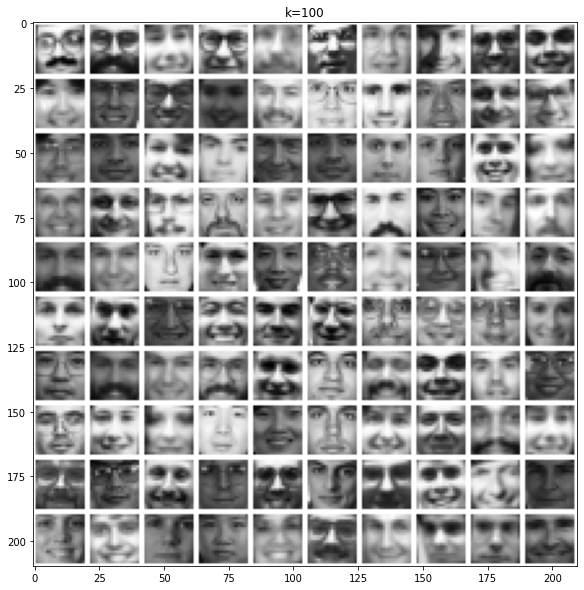

In [101]:
# Print the 100 samples
plt.rcParams["figure.figsize"] = (20,10)
show_images(matX, int(np.sqrt(nSamples)), int(np.sqrt(nSamples)), nSamples)

[--------(8)-----(14)--(17)------(24)--------------(39)-(41)-------------------------------------------------(91)-(93)(94)-----]
target: 9, result: 9
[----(4)-----(10)------------------------(35)----(40)------(47)(48)--(51)(52)---(56)--(59)----(64)----(69)--------(78)--------(87)-------(95)(96)---]
target: 16, result: 16
[--(2)----(7)(8)---(12)(13)(14)-(16)-(18)--(21)--------(30)-(32)----(37)(38)--(41)--(44)--(47)--------------(62)-(64)----------(75)---(79)(80)-------(88)--(91)(92)--(95)----]
target: 25, result: 25


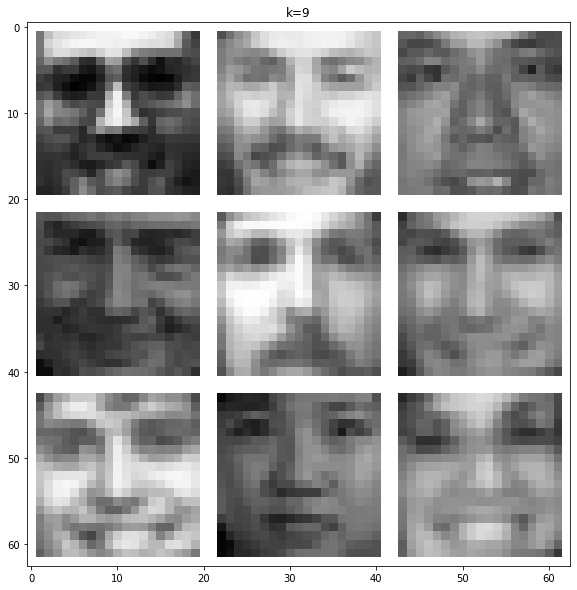

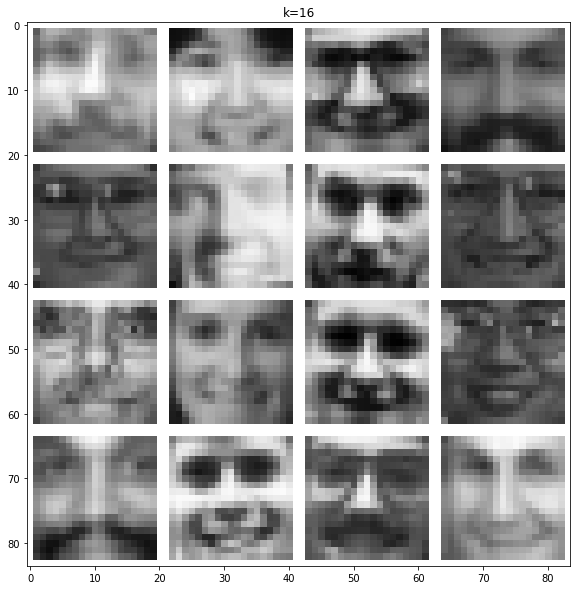

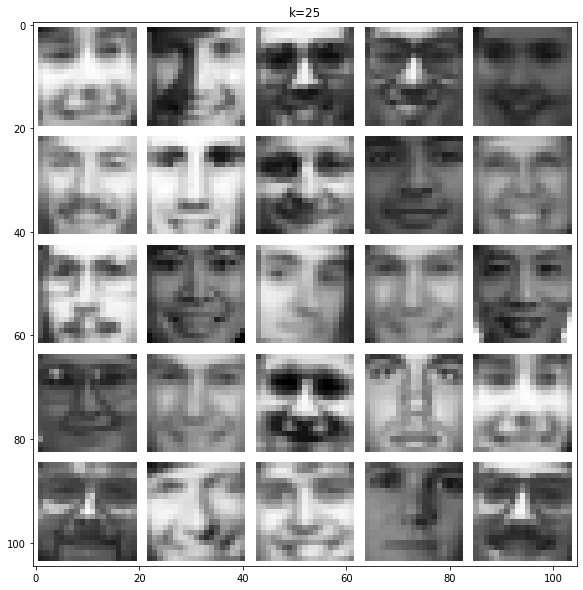

In [102]:
for k in [9, 16, 25]:

    vecP = -lagrange_lambda * 2*k * vec1
    theta = 0.5 * (matP @ vec1 + vecP)
    vecT = theta

    tmax = 1000 
    vecS = -np.ones(n)
    vecS = hnet_run_asyn(vecS, matW, vecT, tmax, verbose=False)

    # Print the results
    mask = np.where(vecS>0, True, False)
    print_bools(mask)
    print (f"target: {k}, result: {np.sum(mask)}")

    ncol = int(np.sqrt(k))
    nrow = int(np.sqrt(k))
    show_images(matX[:,mask], ncol, nrow, fname='t3-5-k%d.png' % k)

In the code above we chose $\lambda = 1000*\text{nSamples} = 100.000$ for the 100 samples we considered.